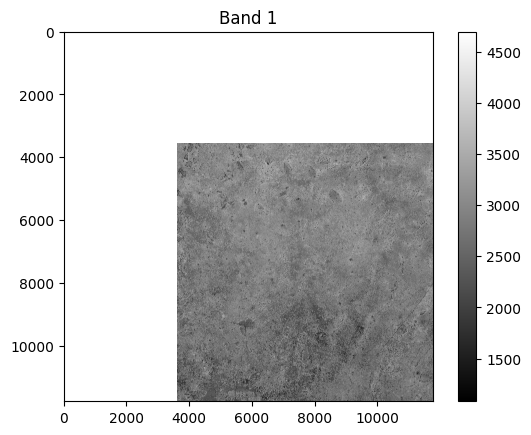

In [1]:
import rasterio
import matplotlib.pyplot as plt

# Pfad zur Ihrer TIFF-Datei
tif_file = 'Nigeria_2018/Nigeria_Sentinel2_Composite-0000000000-0000000000.tif'

# Öffnen der TIFF-Datei
with rasterio.open(tif_file) as src:
    # Lesen des ersten Bandes
    band1 = src.read(1)
    
    # Visualisieren des Bandes mit Matplotlib
    plt.imshow(band1, cmap='gray')
    plt.title('Band 1')
    plt.colorbar()
    plt.show()


In [2]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask

# Load the shapefile
admin_shapes = gpd.read_file('shapefiles/nga_admbnda_adm1_osgof_20190417.shp')

# Load the satellite imagery
sat_image = rasterio.open('Nigeria_2018/Nigeria_2018_Combined.tif')


In [3]:
print(admin_shapes.columns)

Index(['Shape_Leng', 'Shape_Area', 'ADM1_EN', 'ADM1_PCODE', 'ADM1_REF',
       'ADM1ALT1EN', 'ADM1ALT2EN', 'ADM0_EN', 'ADM0_PCODE', 'date', 'validOn',
       'validTo', 'geometry'],
      dtype='object')


In [4]:
print(admin_shapes['ADM1_EN'])

0                          Abia
1                       Adamawa
2                     Akwa Ibom
3                       Anambra
4                        Bauchi
5                       Bayelsa
6                         Benue
7                         Borno
8                   Cross River
9                         Delta
10                       Ebonyi
11                          Edo
12                        Ekiti
13                        Enugu
14    Federal Capital Territory
15                        Gombe
16                          Imo
17                       Jigawa
18                       Kaduna
19                         Kano
20                      Katsina
21                        Kebbi
22                         Kogi
23                        Kwara
24                        Lagos
25                     Nasarawa
26                        Niger
27                         Ogun
28                         Ondo
29                         Osun
30                          Oyo
31      

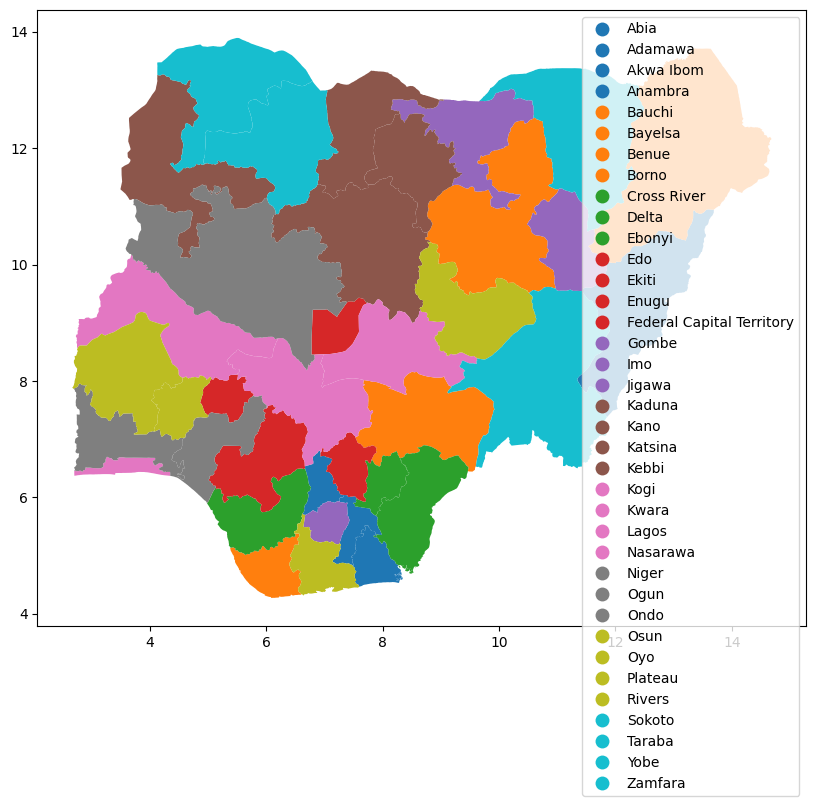

In [5]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# Angenommen, `admin_shapes` ist dein GeoDataFrame mit den Regionen und Geometrien
# Achte darauf, dass die Spalte 'admin1Name' vorhanden ist und die Regionsnamen enthält

# Erstellen Sie ein neues DataFrame für die Geometrien jeder Region
regions_shapes = gpd.GeoDataFrame(columns=['geometry', 'Region'])

# Zuweisen jeder Region und deren Geometrie ins neue DataFrame
for _, row in admin_shapes.iterrows():
    temp_gdf = gpd.GeoDataFrame({'geometry': [row['geometry']], 'Region': [row['ADM1_EN']]})
    regions_shapes = pd.concat([regions_shapes, temp_gdf], ignore_index=True)

# Visualisieren der Geometrien
fig, ax = plt.subplots(figsize=(12, 8))
regions_shapes.plot(ax=ax, column='Region', legend=True)
plt.show()


In [6]:
import random
from shapely.geometry import Point

def sample_unique_coordinates(geometry, num_samples):
    minx, miny, maxx, maxy = geometry.bounds
    coordinates = set()
    
    while len(coordinates) < num_samples:
        # Erzeugen Sie einen zufälligen Punkt
        pnt = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
        # Überprüfen Sie, ob der Punkt innerhalb der Geometrie und nicht bereits im Set enthalten ist
        if geometry.contains(pnt) and pnt not in coordinates:
            coordinates.add(pnt)
    
    return list(coordinates)

random.seed(42)  # Setzen eines Seeds für Reproduzierbarkeit
sampled_coordinates_per_region = {}

for index, row in admin_shapes.iterrows():
    geometry = row['geometry']
    region_name = row['ADM1_EN']  # oder admin1_EN je nach tatsächlicher Spaltenbezeichnung
    sampled_coords = sample_unique_coordinates(geometry, 100)
    sampled_coordinates_per_region[region_name] = sampled_coords

In [7]:
sampled_coordinates_per_region.keys()

dict_keys(['Abia', 'Adamawa', 'Akwa Ibom', 'Anambra', 'Bauchi', 'Bayelsa', 'Benue', 'Borno', 'Cross River', 'Delta', 'Ebonyi', 'Edo', 'Ekiti', 'Enugu', 'Federal Capital Territory', 'Gombe', 'Imo', 'Jigawa', 'Kaduna', 'Kano', 'Katsina', 'Kebbi', 'Kogi', 'Kwara', 'Lagos', 'Nasarawa', 'Niger', 'Ogun', 'Ondo', 'Osun', 'Oyo', 'Plateau', 'Rivers', 'Sokoto', 'Taraba', 'Yobe', 'Zamfara'])

In [8]:
len(sampled_coordinates_per_region['Abia'])

100

In [9]:
import rasterio
from rasterio.windows import Window
import numpy as np
import random

sat_image_path = 'Nigeria_2018/Nigeria_2018_Combined.tif'

def extract_images_and_labels(coords_with_labels, image_path, size=224):
    images = []
    labels = []
    with rasterio.open(image_path) as src:
        for coord_label in coords_with_labels:
            # Berechnen Sie die Pixelkoordinaten
            row, col = src.index(coord_label['coordinates'][0], coord_label['coordinates'][1])
            # Erzeugen Sie ein Fenster um den Punkt
            window = Window(col - size // 2, row - size // 2, size, size)
            # Lesen Sie die Daten im Fenster
            image = src.read(window=window)
            # Fügen Sie das Bild und das Label zu den Listen hinzu
            images.append(image)
            labels.append(coord_label['region_name'])
    return images, labels

# Listen für Training und Test erstellen
train_images = []
train_labels = []
test_images = []
test_labels = []

# Für jede Region separat mischen und aufteilen
for region, points in sampled_coordinates_per_region.items():
    # Erstellen Sie eine Liste von Koordinaten mit Labels für die Region
    region_coords_labels = [{'coordinates': (point.x, point.y), 'region_name': region} for point in points]
    # Mischen Sie die Koordinaten
    random.shuffle(region_coords_labels)
    # Teilen Sie in Trainings- und Testdaten
    split_index = len(region_coords_labels) // 10
    test_region = region_coords_labels[:split_index]
    train_region = region_coords_labels[split_index:]
    # Bilder für die Region extrahieren und zu den entsprechenden Listen hinzufügen
    train_images_region, train_labels_region = extract_images_and_labels(train_region, sat_image_path)
    test_images_region, test_labels_region = extract_images_and_labels(test_region, sat_image_path)
    # Fügen Sie die regionalen Daten zu den Gesamtdaten hinzu
    train_images.extend(train_images_region)
    train_labels.extend(train_labels_region)
    test_images.extend(test_images_region)
    test_labels.extend(test_labels_region)


# Jetzt können Sie `train_images` und `train_labels` verwenden, um Ihr Modell zu trainieren
# und `test_images` und `test_labels` zum Testen des Modells.


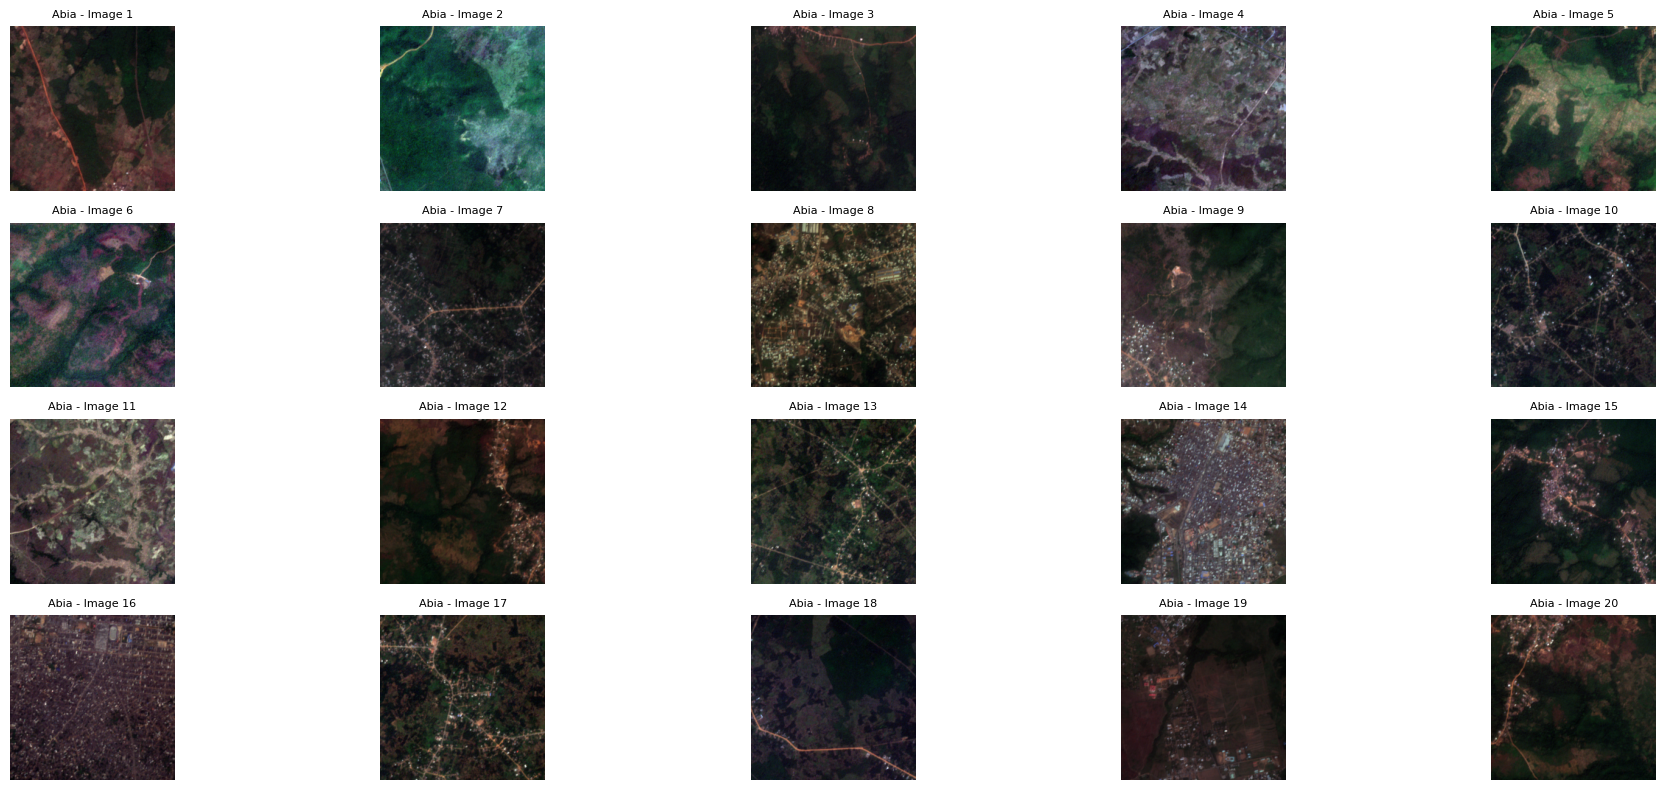

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Nehmen wir an, dass train_images eine Liste von Arrays ist, die die Bilddaten enthält.
# train_images = [...]

# Überprüfen, ob mindestens 20 Bilder vorhanden sind
assert len(train_images) >= 20, "Nicht genügend Trainingsbilder verfügbar."

# Anzahl der anzuzeigenden Bilder
num_images = 20
num_rows = 4  # Für 20 Bilder verwenden wir 4 Zeilen
num_cols = 5  # und 5 Spalten

# Erstellen der Subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 8))

# Bilder anzeigen
for i in range(num_images):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]

    # Angenommen, jedes Bild hat Bänder in der ersten Dimension und ist 100x100 Pixel groß
    img = train_images[i]
    # Normalisieren und anzeigen, nehmen Sie die ersten drei Bänder für RGB
    img_norm = np.zeros((img.shape[1], img.shape[2], 3))
    for band in range(3):
        img_band = img[band, :, :]
        img_norm[:, :, band] = (img_band - img_band.min()) / (img_band.max() - img_band.min())
    
    ax.imshow(img_norm, aspect='equal')
    ax.set_title(f'{train_labels[i]} - Image {i+1}', fontsize=8)
    ax.axis('off')

plt.tight_layout()
plt.show()


In [11]:
train_images[0].shape

(4, 224, 224)

In [12]:
import pandas as pd
import numpy as np

# Laden der MPI-Daten aus einer CSV-Datei
mpi_data = pd.read_csv('nigeria_mpi_only.csv')

# Erstellen eines Dictionaries, um Regionsnamen auf MPI-Werte abzubilden
mpi_dict = pd.Series(mpi_data.mpi.values, index=mpi_data.region).to_dict()

# Zuordnen von MPI-Werten zu Ihren Trainings- und Testetiketten
train_mpi_scores = np.array([mpi_dict[region] for region in train_labels])
test_mpi_scores = np.array([mpi_dict[region] for region in test_labels])


In [13]:
# Konvertieren der Liste in ein NumPy-Array und Transponieren der Achsen
train_images_np = np.array(train_images).transpose(0, 2, 3, 1)
test_images_np = np.array(test_images).transpose(0, 2, 3, 1)

# Entfernen des Infrarotkanals, um nur die ersten drei RGB-Kanäle zu behalten
train_images_np = train_images_np[:, :, :, :3]
test_images_np = test_images_np[:, :, :, :3]


In [14]:
train_images_np.shape

(3330, 224, 224, 3)

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

np.random.seed(42)

datagen = ImageDataGenerator(
    rotation_range=90,
    horizontal_flip=True,
    zoom_range=0.2,  # Zufälliges Zoomen innerhalb dieses Bereichs
    shear_range=0.2,  # Scherintensität
    brightness_range=[0.5, 1.5],  # Helligkeitsbereich für Anpassungen
    fill_mode='nearest'
)


# Angenommen, `train_images_rgb` ist Ihr vorbereitetes Trainingsdatenset
# Sie müssen die Daten möglicherweise in die Form (Anzahl, Höhe, Breite, Kanäle) bringen

# Die Augmentation durchführen
augmented_images = []
for i in range(len(train_images_np)):
    img = np.expand_dims(train_images_np[i], axis=0)  # Bild in ein Batch umwandeln
    it = datagen.flow(img, batch_size=1)
    for _ in range(10):  # Generieren Sie 4 augmentierte Bilder pro Originalbild
        aug_img = next(it)
        augmented_images.append(aug_img[0])

# Jetzt `augmented_images` als erweiterten Trainingsdatensatz verwenden


In [16]:
# Angenommen, jedes Originalbild wurde in vier augmentierte Bilder umgewandelt
augmented_mpi_scores = np.repeat(train_mpi_scores, 10)

# Konvertieren Sie augmented_images in ein NumPy-Array für das Training
augmented_images_np = np.array(augmented_images)


In [17]:
import torch

if torch.cuda.is_available():
    print("Eine GPU ist verfügbar.")
else:
    print("Keine GPU verfügbar.")


Eine GPU ist verfügbar.


In [18]:
# Vor dem Konvertieren in Tensoren und Übertragen auf das Gerät
augmented_images_np = np.transpose(augmented_images_np, (0, 3, 1, 2))

In [19]:
augmented_images_np.shape

(33300, 3, 224, 224)

In [20]:
import torch
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader, TensorDataset
from torch import nn, optim
from tqdm import tqdm
from torchvision.models.resnet import ResNet101_Weights

# Stelle sicher, dass CUDA verfügbar ist
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Lade das vortrainierte ResNet-101 Modell
model = models.resnet101(weights=ResNet101_Weights.DEFAULT)

# Freeze aller Schichten
for param in model.parameters():
    param.requires_grad = False

# Ersetze die letzte Schicht für die Regression
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 32),
    nn.ReLU(),
    nn.Linear(32, 1)
)

# Modell auf die GPU verschieben
model = model.to(device)

# Verlustfunktion und Optimierer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# Daten-Transformations-Pipeline für die Eingabebilder
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Ersetze den folgenden Pseudocode mit deinem eigenen Code, um deine Daten zu laden
# Vor dem Konvertieren in Tensoren und Übertragen auf das Gerät
train_images_cuda = torch.tensor(augmented_images_np, dtype=torch.float).to(device)
train_labels_cuda = torch.tensor(augmented_mpi_scores, dtype=torch.float).unsqueeze(1).to(device)


# Daten in DataLoader umwandeln
train_dataset_cuda = TensorDataset(train_images_cuda, train_labels_cuda)
train_loader_cuda = DataLoader(train_dataset_cuda, batch_size=32, shuffle=True)

# Trainingsschleife
model.train()
for epoch in range(50):  # Anzahl der Epochen
    epoch_loss = 0
    for inputs, labels in tqdm(train_loader_cuda, desc=f'Epoch {epoch+1}'):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f'Epoch {epoch+1}, Average Loss: {epoch_loss / len(train_loader_cuda)}')


Epoch 1: 100%|██████████| 1041/1041 [00:24<00:00, 42.02it/s]


Epoch 1, Average Loss: 0.007286243149532071


Epoch 2: 100%|██████████| 1041/1041 [00:23<00:00, 45.21it/s]


Epoch 2, Average Loss: 0.0053515211307988515


Epoch 3: 100%|██████████| 1041/1041 [00:22<00:00, 46.20it/s]


Epoch 3, Average Loss: 0.0050582747581467665


Epoch 4: 100%|██████████| 1041/1041 [00:22<00:00, 46.14it/s]


Epoch 4, Average Loss: 0.005056681904555312


Epoch 5: 100%|██████████| 1041/1041 [00:22<00:00, 46.10it/s]


Epoch 5, Average Loss: 0.004885341352237412


Epoch 6: 100%|██████████| 1041/1041 [00:22<00:00, 46.06it/s]


Epoch 6, Average Loss: 0.004789475566398005


Epoch 7: 100%|██████████| 1041/1041 [00:22<00:00, 46.07it/s]


Epoch 7, Average Loss: 0.0046556620079376285


Epoch 8: 100%|██████████| 1041/1041 [00:22<00:00, 46.04it/s]


Epoch 8, Average Loss: 0.0045669855553062775


Epoch 9: 100%|██████████| 1041/1041 [00:22<00:00, 46.05it/s]


Epoch 9, Average Loss: 0.004438066043408801


Epoch 10: 100%|██████████| 1041/1041 [00:22<00:00, 46.04it/s]


Epoch 10, Average Loss: 0.004431325130054582


Epoch 11: 100%|██████████| 1041/1041 [00:22<00:00, 45.99it/s]


Epoch 11, Average Loss: 0.004300475349684678


Epoch 12: 100%|██████████| 1041/1041 [00:22<00:00, 46.03it/s]


Epoch 12, Average Loss: 0.004282226836452874


Epoch 13: 100%|██████████| 1041/1041 [00:22<00:00, 46.02it/s]


Epoch 13, Average Loss: 0.004280418255764501


Epoch 14: 100%|██████████| 1041/1041 [00:22<00:00, 46.05it/s]


Epoch 14, Average Loss: 0.004219094314254592


Epoch 15: 100%|██████████| 1041/1041 [00:22<00:00, 46.02it/s]


Epoch 15, Average Loss: 0.004223411477942066


Epoch 16: 100%|██████████| 1041/1041 [00:22<00:00, 46.06it/s]


Epoch 16, Average Loss: 0.004156973220226351


Epoch 17: 100%|██████████| 1041/1041 [00:22<00:00, 45.91it/s]


Epoch 17, Average Loss: 0.004110884803502063


Epoch 18: 100%|██████████| 1041/1041 [00:22<00:00, 45.44it/s]


Epoch 18, Average Loss: 0.004117667923281533


Epoch 19: 100%|██████████| 1041/1041 [00:22<00:00, 45.55it/s]


Epoch 19, Average Loss: 0.004032604434701018


Epoch 20: 100%|██████████| 1041/1041 [00:22<00:00, 45.51it/s]


Epoch 20, Average Loss: 0.004032728339017143


Epoch 21: 100%|██████████| 1041/1041 [00:22<00:00, 45.65it/s]


Epoch 21, Average Loss: 0.003968653972971895


Epoch 22: 100%|██████████| 1041/1041 [00:22<00:00, 45.63it/s]


Epoch 22, Average Loss: 0.00399695004296948


Epoch 23: 100%|██████████| 1041/1041 [00:22<00:00, 45.65it/s]


Epoch 23, Average Loss: 0.0039050541151633466


Epoch 24: 100%|██████████| 1041/1041 [00:22<00:00, 45.65it/s]


Epoch 24, Average Loss: 0.0038756149527764414


Epoch 25: 100%|██████████| 1041/1041 [00:22<00:00, 45.62it/s]


Epoch 25, Average Loss: 0.0039417638394652395


Epoch 26: 100%|██████████| 1041/1041 [00:22<00:00, 45.47it/s]


Epoch 26, Average Loss: 0.003875721686615409


Epoch 27: 100%|██████████| 1041/1041 [00:22<00:00, 45.69it/s]


Epoch 27, Average Loss: 0.0038266572293867494


Epoch 28: 100%|██████████| 1041/1041 [00:22<00:00, 45.57it/s]


Epoch 28, Average Loss: 0.003733571481579641


Epoch 29: 100%|██████████| 1041/1041 [00:22<00:00, 45.59it/s]


Epoch 29, Average Loss: 0.0037836924379362254


Epoch 30: 100%|██████████| 1041/1041 [00:22<00:00, 45.64it/s]


Epoch 30, Average Loss: 0.0037890493056887188


Epoch 31: 100%|██████████| 1041/1041 [00:22<00:00, 45.60it/s]


Epoch 31, Average Loss: 0.0038199743603653203


Epoch 32: 100%|██████████| 1041/1041 [00:22<00:00, 45.62it/s]


Epoch 32, Average Loss: 0.0037477330666900533


Epoch 33: 100%|██████████| 1041/1041 [00:22<00:00, 45.60it/s]


Epoch 33, Average Loss: 0.00372260719916616


Epoch 34: 100%|██████████| 1041/1041 [00:22<00:00, 45.62it/s]


Epoch 34, Average Loss: 0.003762571085711868


Epoch 35: 100%|██████████| 1041/1041 [00:22<00:00, 45.62it/s]


Epoch 35, Average Loss: 0.003669976220107445


Epoch 36: 100%|██████████| 1041/1041 [00:22<00:00, 45.66it/s]


Epoch 36, Average Loss: 0.0036830184907418934


Epoch 37: 100%|██████████| 1041/1041 [00:22<00:00, 45.47it/s]


Epoch 37, Average Loss: 0.0037535448019271117


Epoch 38: 100%|██████████| 1041/1041 [00:22<00:00, 45.67it/s]


Epoch 38, Average Loss: 0.0036385560416174545


Epoch 39: 100%|██████████| 1041/1041 [00:22<00:00, 45.59it/s]


Epoch 39, Average Loss: 0.0037063149036168624


Epoch 40: 100%|██████████| 1041/1041 [00:22<00:00, 45.65it/s]


Epoch 40, Average Loss: 0.0036961284224981735


Epoch 41: 100%|██████████| 1041/1041 [00:22<00:00, 45.65it/s]


Epoch 41, Average Loss: 0.0036946195636797198


Epoch 42: 100%|██████████| 1041/1041 [00:22<00:00, 45.54it/s]


Epoch 42, Average Loss: 0.003655906477515871


Epoch 43: 100%|██████████| 1041/1041 [00:22<00:00, 45.57it/s]


Epoch 43, Average Loss: 0.0036365110466281786


Epoch 44: 100%|██████████| 1041/1041 [00:22<00:00, 45.67it/s]


Epoch 44, Average Loss: 0.003702933926450216


Epoch 45: 100%|██████████| 1041/1041 [00:22<00:00, 45.67it/s]


Epoch 45, Average Loss: 0.003635469398896973


Epoch 46: 100%|██████████| 1041/1041 [00:22<00:00, 45.67it/s]


Epoch 46, Average Loss: 0.003654842933471691


Epoch 47: 100%|██████████| 1041/1041 [00:22<00:00, 45.65it/s]


Epoch 47, Average Loss: 0.003730696959038132


Epoch 48: 100%|██████████| 1041/1041 [00:22<00:00, 45.66it/s]


Epoch 48, Average Loss: 0.0035493039591130543


Epoch 49: 100%|██████████| 1041/1041 [00:22<00:00, 45.69it/s]


Epoch 49, Average Loss: 0.0034951879044611803


Epoch 50: 100%|██████████| 1041/1041 [00:22<00:00, 45.53it/s]

Epoch 50, Average Loss: 0.0035795105665279814


In [21]:
test_images_np = np.transpose(test_images_np, (0, 3, 1, 2))

In [22]:
print(test_images_np.shape, augmented_images_np.shape)

(370, 3, 224, 224) (33300, 3, 224, 224)


In [23]:
model.eval()
with torch.no_grad():
    test_images_tensor = torch.tensor(test_images_np).float().to(device)
    predicted_mpi_scores_tensor = model(test_images_tensor)
    predicted_mpi_scores = predicted_mpi_scores_tensor.view(-1).cpu().numpy()

# Vorhersagen in ein flaches Array konvertieren, falls sie nicht bereits flach sind
predicted_mpi_scores = predicted_mpi_scores.flatten()

# Annahme: Jede Region hat eine gleiche Anzahl von Testbildern, die in der Reihenfolge in `test_labels` enthalten sind
unique_test_regions, test_region_indices = np.unique(test_labels, return_inverse=True)
num_images_per_region = len(test_images) // len(unique_test_regions)
agg_predicted_scores = np.array([predicted_mpi_scores[test_region_indices == i].mean() for i in range(len(unique_test_regions))])

# Bereiten Sie die tatsächlichen MPI-Werte für die Testregionen vor
actual_mpi_scores = np.array([mpi_dict[region] for region in unique_test_regions])

# Leistungsmetriken berechnen
mse = np.mean((agg_predicted_scores - actual_mpi_scores)**2)
mae = np.mean(np.abs(agg_predicted_scores - actual_mpi_scores))
rmse = np.sqrt(mse)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')


Mean Squared Error (MSE): 0.0030984218348705673
Root Mean Squared Error (RMSE): 0.05566346948287151
Mean Absolute Error (MAE): 0.03867797873954515


In [24]:
from sklearn.metrics import mean_squared_error, r2_score

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_mpi_scores, agg_predicted_scores))

# Calculate R-squared (R²)
r2 = r2_score(actual_mpi_scores, agg_predicted_scores)

print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R-squared (R²): {r2}')


Root Mean Squared Error (RMSE): 0.05566346948287151
R-squared (R²): 0.8657190990148582


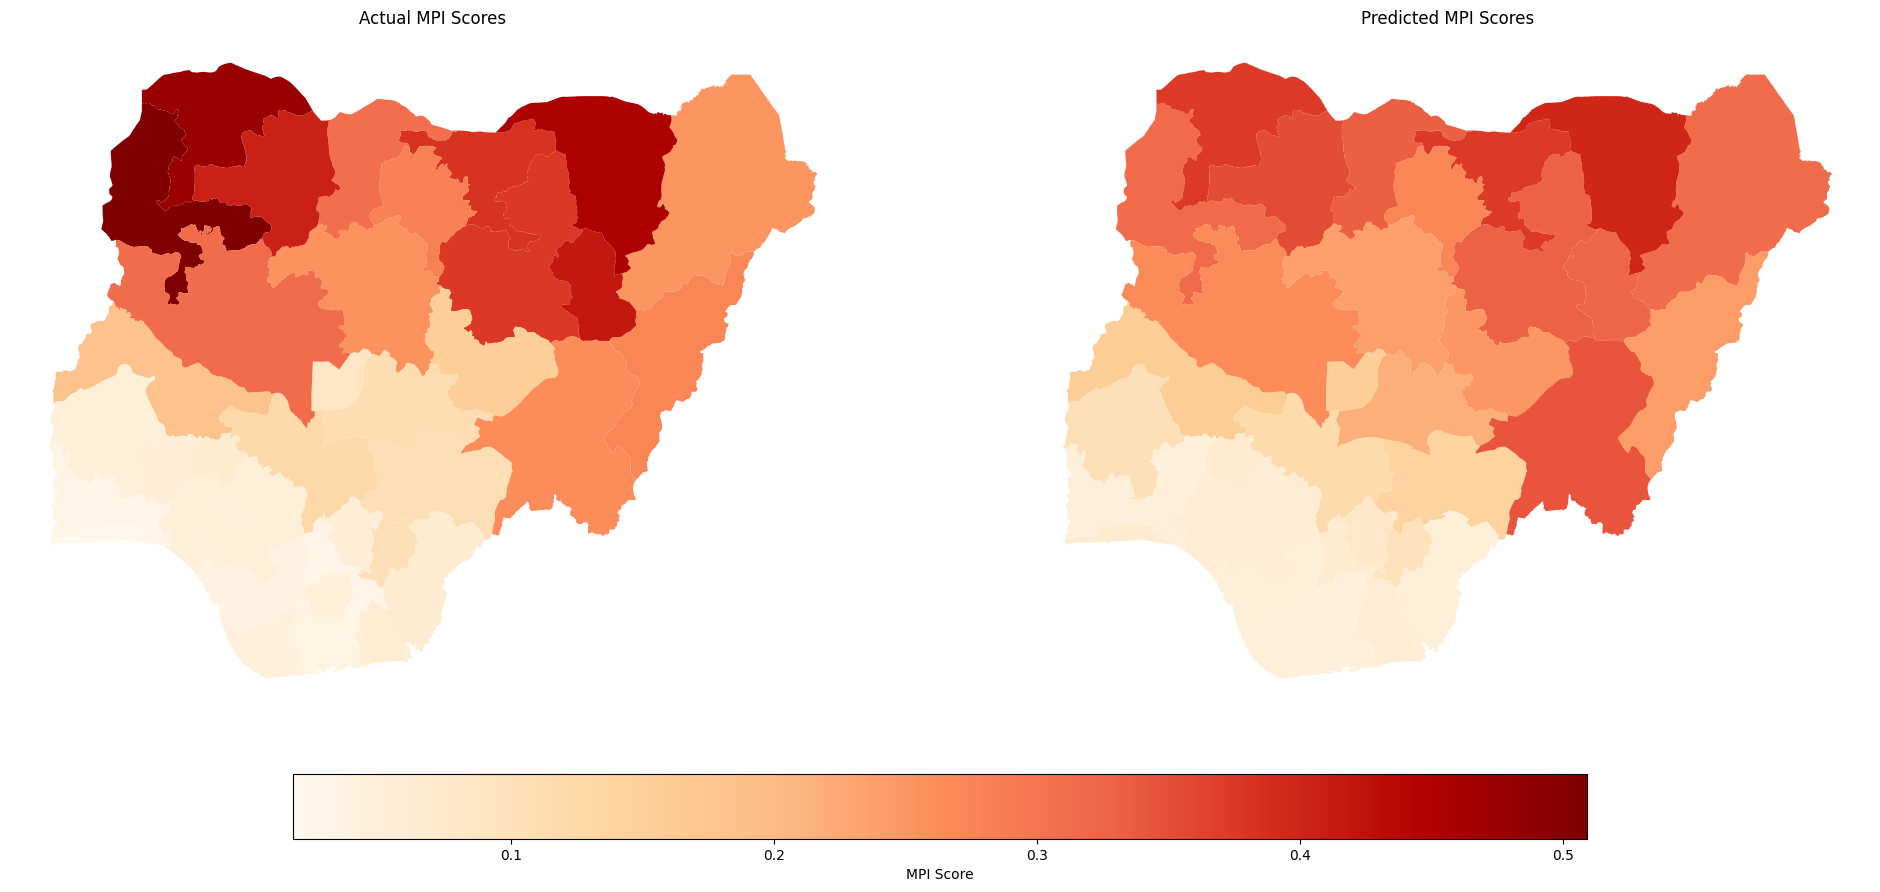

In [25]:
import matplotlib.pyplot as plt

# Erstelle ein GeoDataFrame für die Geometrien jeder Region
regions_shapes = gpd.GeoDataFrame(columns=['geometry', 'Region'])
for _, row in admin_shapes.iterrows():
    temp_gdf = gpd.GeoDataFrame({'geometry': [row['geometry']], 'Region': [row['ADM1_EN']]})
    regions_shapes = pd.concat([regions_shapes, temp_gdf], ignore_index=True)

# Verknüpfe MPI-Daten
regions_shapes = regions_shapes.merge(mpi_data, left_on='Region', right_on='region', how='left')


# Erstelle ein DataFrame für die vorhergesagten Werte
predicted_df = pd.DataFrame({
    'Region': unique_test_regions,
    'Predicted_MPI': agg_predicted_scores
})

# Verknüpfe die vorhergesagten Werte mit den geografischen Daten
regions_shapes = regions_shapes.merge(predicted_df, on='Region', how='left')

# Bestimme die Skalierung für die Farbkarte basierend auf dem kombinierten Bereich der tatsächlichen und vorhergesagten Werte
vmin = min(regions_shapes['mpi'].min(), regions_shapes['Predicted_MPI'].min())
vmax = max(regions_shapes['mpi'].max(), regions_shapes['Predicted_MPI'].max())

# Definiere die Figur und die Achsen
fig, axes = plt.subplots(1, 2, figsize=(24, 12))  # Zwei Subplots nebeneinander

# Plot der tatsächlichen MPI-Werte
regions_shapes.plot(ax=axes[0], column='mpi', cmap='OrRd', vmin=vmin, vmax=vmax)
axes[0].set_title('Actual MPI Scores')
axes[0].set_axis_off()

# Plot der vorhergesagten MPI-Werte
regions_shapes.plot(ax=axes[1], column='Predicted_MPI', cmap='OrRd', vmin=vmin, vmax=vmax)
axes[1].set_title('Predicted MPI Scores')
axes[1].set_axis_off()

# Add a colorbar to the figure instead of the individual plots
fig.colorbar(plt.cm.ScalarMappable(cmap='OrRd', norm=plt.Normalize(vmin=vmin, vmax=vmax)), ax=axes.ravel().tolist(), orientation='horizontal', fraction=0.07, pad=0.07, label='MPI Score')

plt.show()
